### Introduction to Audio Processing

### Course Project: 

### Separation of drums from music signals

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
import librosa
import sounddevice as sd

#### Reading the audio, normalizing the audio signal, applying window length and setting 50% overlap

In [2]:
#fs,audIn = wavfile.read('police03short.wav') # Read audio file
fs,audIn = wavfile.read('project_test1.wav') # Read audio file
samples_t = len(audIn)
dur = samples_t/float(fs) # Duration

audIn = audIn.astype('float64') # Normalize x so that its value is between [-1.00, 1.00]
audIn = 2*(audIn-np.min(audIn))/(np.max(audIn)-np.min(audIn))-1 
win_len = 1024 # setting the window length in samples
hop_len = int(win_len/2)# setting an overlap ratio of 50 %


#### Computing spectrogram of x(t)

In [3]:
_input = librosa.stft(audIn, n_fft=win_len, hop_length=hop_len)
num_freq, num_tf = _input.shape
f_scale = np.linspace(0, fs / 2, num_freq)
tf_scale = np.linspace(0, dur, num_tf)

#### Function to plot spectrograms

In [4]:
def plt_specgram(_input):
    t_s = 20 * np.log10(np.abs(_input+ 1e-10))
    plt.pcolormesh(tf_scale, f_scale, t_s)
    plt.xlabel('Time (s)')
    plt.ylabel('Frequency (Hz)')

#### Plotting the original spectrogram

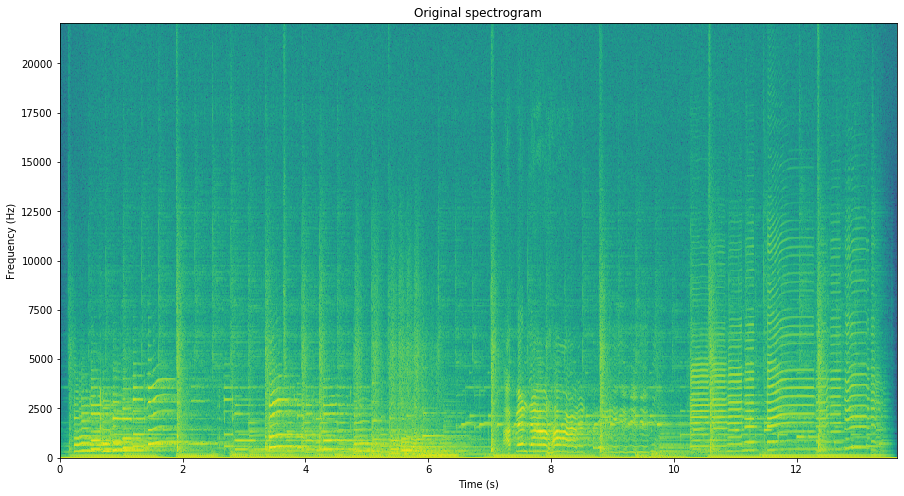

In [5]:
plt_s = 1
plt.figure(plt_s,figsize=(15, 8))
plt_specgram(_input)
plt.title('Original spectrogram')
plt.show()

#### Parameters of the algorithm and initialization

In [6]:
gamma = 0.3
alpha=0.3
k_max=51
W = np.abs(_input)**(2*gamma)
H = 0.5*W
P = H

#### Loop to update H(h,i) and P(h,i)

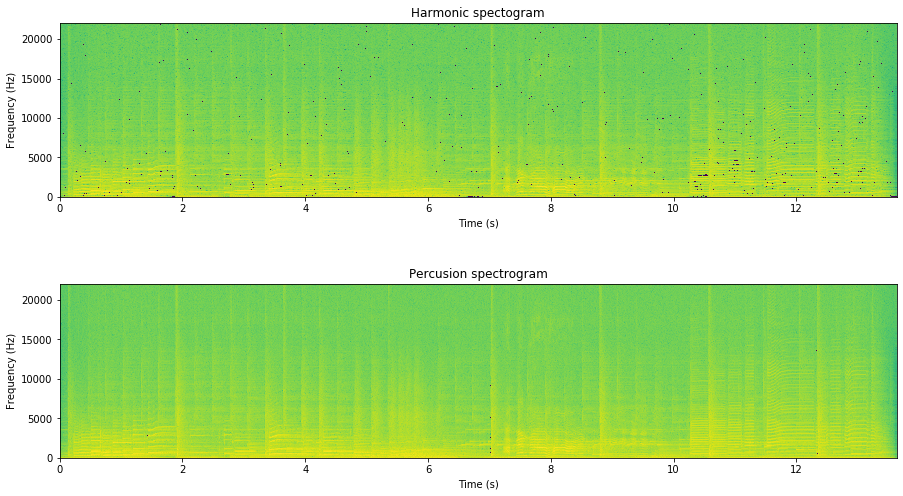

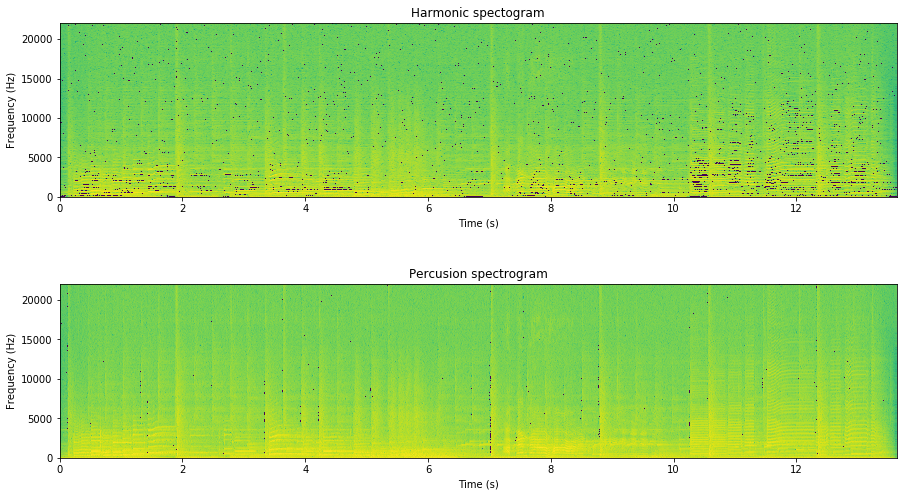

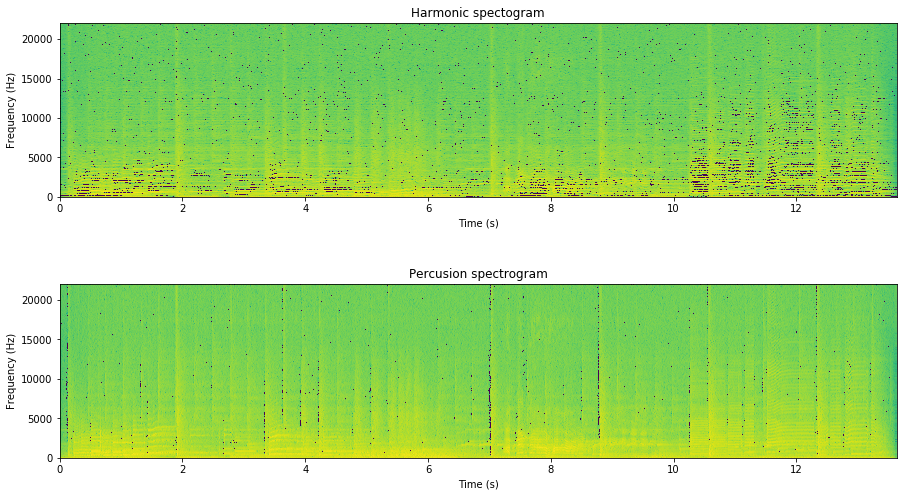

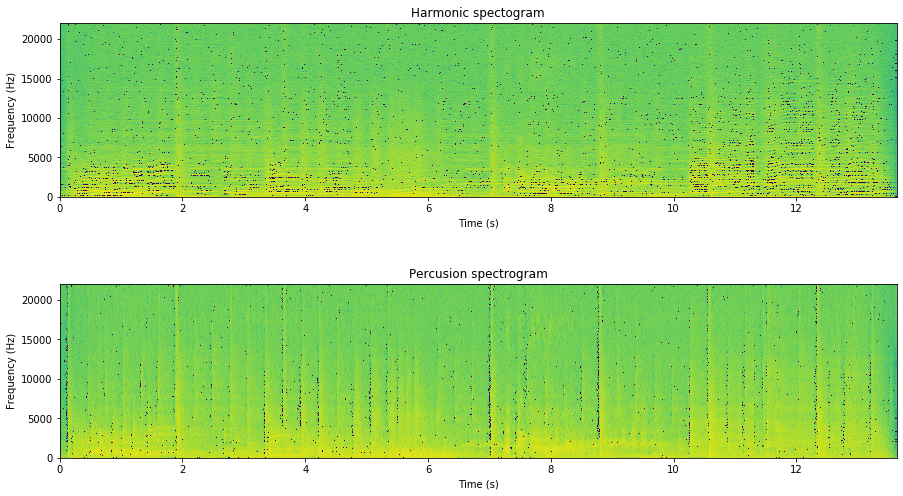

In [7]:
for k in range(k_max):
    
    Hp = np.roll(H,1, axis=1)# H(h,i-1)
    Hp[:,0] = 0
    Hf = np.roll(H,-1, axis=1)# H(h,i+1)
    Hf[:,-1] = 0
    Pp = np.roll(P,1, axis=0)# P(h-1,i)
    Pp[0,:] = 0
    Pf = np.roll(P,-1, axis=0)# P(h+1,i)
    Pf[-1,:] = 0
    
    delta = alpha*(Hp - 2*H + Hf)/4 - (1-alpha)*(Pp - 2*P + Pf)/4 # Delta Computation
    H = np.minimum(np.maximum(H+delta,0),W) # updating H(h,i) and P(h,i)
    P = W - H
    vals = [0, 3, 10, 50]  # values of "vals" to save figures
    
    if k in vals:
        
        # Plot iteratively-updated components H(h,i) and P(h,i)
        plt_s+=1
        plt.figure(plt_s,figsize=(15, 8))
        plt.subplot(211)
        plt_specgram(H)
        plt.title('Harmonic spectogram')

        plt.subplot(212)
        plt_specgram(P)
        plt.subplots_adjust(wspace= 0.5, hspace = 0.5)
        plt.title('Percusion spectrogram')
        plt.show()        

#### Binarizing components with masking.

Text(0.5, 1.0, 'Harmonic spectogram')

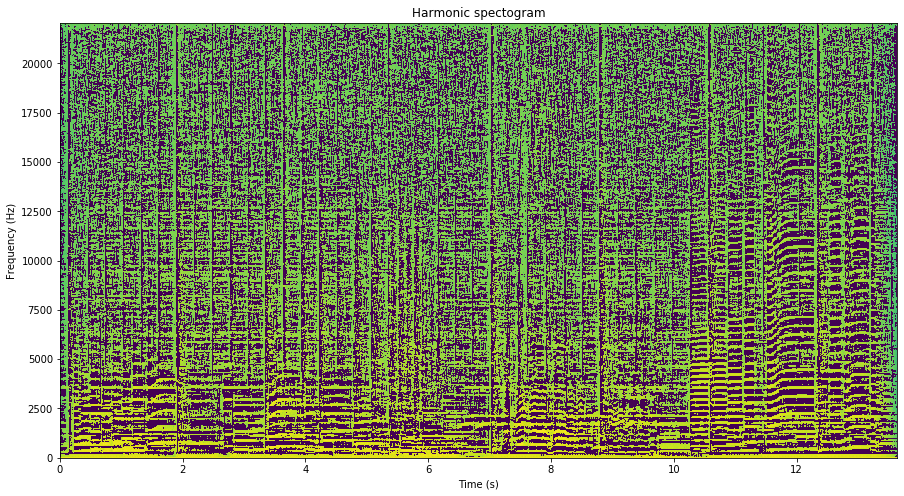

In [16]:
mask = H<P
H_kmax = np.zeros_like(H)
P_kmax = np.zeros_like(P)
H_kmax[mask] = 0
P_kmax[mask] = W[mask]
H_kmax[~mask] = W[~mask]
P_kmax[~mask] = 0

plt_s+=1
plt.figure(plt_s,figsize=(15, 8))
plt_specgram(H_kmax)
plt.title('Harmonic spectogram')

#### Plotting the binarized Harmonic spectogram 

Text(0.5, 1.0, 'Harmonic spectogram')

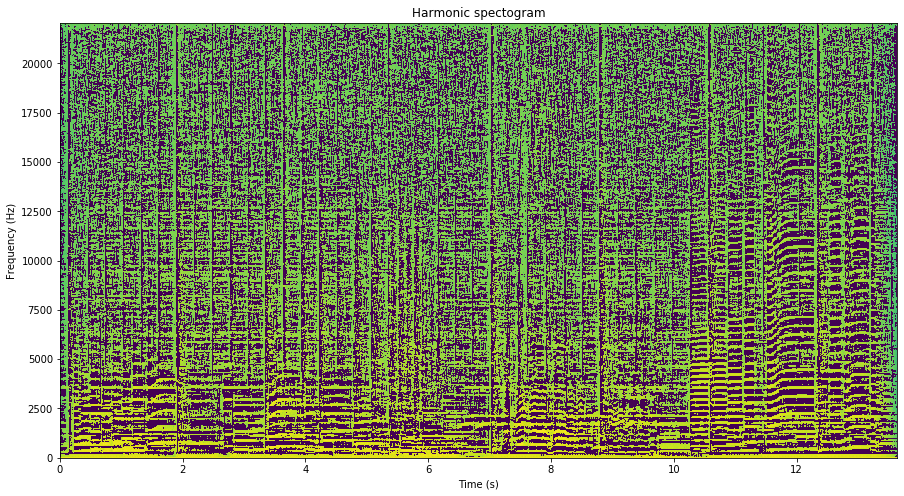

In [9]:
plt_s+=1
plt.figure(plt_s,figsize=(15, 8))
plt_specgram(H_kmax)
plt.title('Harmonic spectogram')

 #### Plotting the binarized Percusion Spectrogram

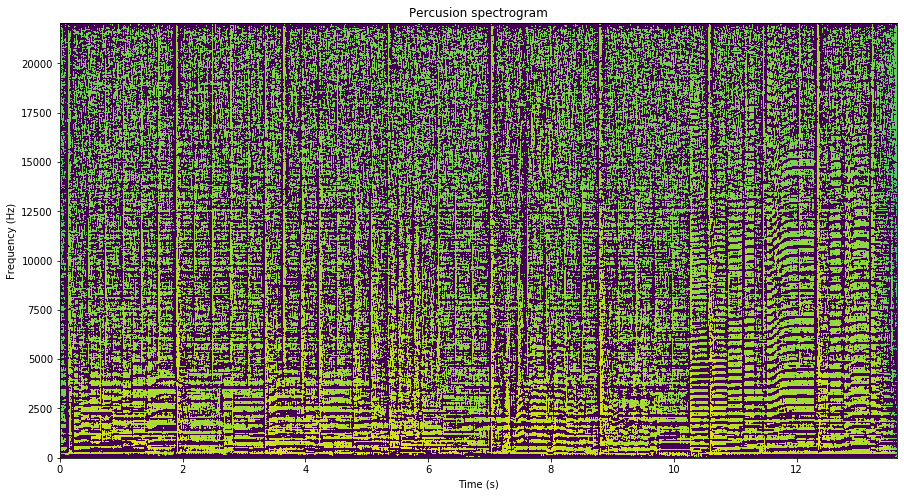

In [15]:

plt.figure(plt_s,figsize=(15, 8))
plt_specgram(P_kmax)
plt.title('Percusion spectrogram')
plt.show()

#### Applying ISTFT to get h(t) and p(t)

In [11]:
Hc = ((H_kmax)**(1/(2*gamma)))*np.e**(1j*np.angle(_input))
Pc = ((P_kmax)**(1/(2*gamma)))*np.e**(1j*np.angle(_input))
h = librosa.istft(Hc, win_length=win_len, hop_length=hop_len, length = len(audIn))
p = librosa.istft(Pc, win_length=win_len, hop_length=hop_len, length = len(audIn))

h = h.astype('float64') 
p = p.astype('float64')
mix_sep_com = h+p # sum of separated components
error = audIn - mix_sep_com # Error signal

#### Printing the range of Error(Original minus the separated signal), range of Original signal and range of seperated components

In [12]:
print("Range of error: {" + str(np.min(error)) + " , " + str(np.max(error)) + "}")
print("Range of audIn: {" + str(np.min(audIn)) + " , " + str(np.max(audIn)) + "}")
print("Range of sum of separated components: {" + str(np.min(mix_sep_com)) + " , " + str(np.max(mix_sep_com)) + "}")

Range of error: {-2.1771738056841627e-07 , 2.5139380788186116e-07}
Range of audIn: {-1.0 , 1.0}
Range of sum of separated components: {-0.9999999143183231 , 1.0000000596046448}


#### Computing SNR(Signal-to-Noise Ratio) value

In [13]:
ratio_snr = 10*np.log10(np.sum(audIn**2)/np.sum(error**2))
print("Signal-to-Noise Ratio (SNR): ", ratio_snr)

Signal-to-Noise Ratio (SNR):  136.51801758932362


#### Saving separated components h(t) and p(t)

In [14]:
librosa.output.write_wav('harmonics.wav', h, int(fs), norm = True)
librosa.output.write_wav('percusion.wav', p, int(fs), norm = True)

#librosa.output.write_wav('harmonics_policeShort.wav', h, int(fs), norm = True)
#librosa.output.write_wav('percusion1_policeShort.wav', p, int(fs), norm = True)

### Observations:
#### 1. What kind of audio material is the algorithm suitable for and why?

Answer: Algorithm is suitable for mono signals because mono audio signal is distributed with the same level to both channels/speakers.


#### 2. How should the separation quality be measured and assessed?

Answer: Seperation quality can be measured by calculating the Signal to Noise ratio which is assesed by the logarithmic summation of the square of the original signal by the square of original minus seperated signal.  